In [ ]:
from google.colab import files

# Upload kaggle.json from your local machine
files.upload()  # Upload your kaggle.json here


{}

In [ ]:
# Setup Kaggle API
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download and unzip dataset
!kaggle datasets download -d abishekdaskhna/oasis-alzheimers-detection
!unzip -q oasis-alzheimers-detection.zip -d ./alzheimer_mri


mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 1741, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'
unzip:  cannot find or open oasis-alzheimers-detection.zip, oasis-alzheimers-detection.zip.zip or oasis-alzheimers-detection.zip.ZIP.


In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("aryansinghal10/alzheimers-multiclass-dataset-equal-and-augmented")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'alzheimers-multiclass-dataset-equal-and-augmented' dataset.
Path to dataset files: /kaggle/input/alzheimers-multiclass-dataset-equal-and-augmented


In [4]:
import os

data_path = "/kaggle/input/alzheimers-multiclass-dataset-equal-and-augmented/combined_images"

if os.path.exists(data_path):
    classes = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]
    print("Classes detected:", classes)

    for cls in classes:
        cls_path = os.path.join(data_path, cls)
        images = [f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff'))]
        print(f"{cls}: {len(images)} images")
else:
    print("Dataset folder not found!")


Classes detected: ['ModerateDemented', 'NonDemented', 'VeryMildDemented', 'MildDemented']
ModerateDemented: 10000 images
NonDemented: 12800 images
VeryMildDemented: 11200 images
MildDemented: 10000 images


In [3]:
# ==========================
# SET YOUR LOCAL DATA PATH HERE
# ==========================
# Replace this with your actual local dataset path
# Example: data_path = r"C:\Users\RAMYA\Documents\alzheimer_dataset\combined_images"
data_path = r"C:\Users\RAMYA\OneDrive\Documents\projects\alzymers\data\combined_images"  # Update this path!

print(f"Using dataset path: {data_path}")
print(f"Path exists: {os.path.exists(data_path)}")


Using dataset path: C:\Users\RAMYA\OneDrive\Documents\projects\alzymers\data\combined_images
Path exists: False


In [6]:
# ==========================
# 1. Imports
# ==========================
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize

# ==========================
# 2. Config - IMPROVED
# ==========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32  # Reduced for better gradient updates
epochs = 20      # Increased for better convergence
input_size = 224
learning_rate = 0.001  # Increased learning rate
# data_path = "/kaggle/input/alzheimers-multiclass-dataset-equal-and-augmented/combined_images"

# ==========================
# 3. Verify Dataset
# ==========================
if os.path.exists(data_path):
    classes = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]
    print("✅ Classes detected:", classes)
    for cls in classes:
        cls_path = os.path.join(data_path, cls)
        images = [f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg','.jpeg','.png','.bmp','.tif','.tiff'))]
        print(f"{cls}: {len(images)} images")
else:
    raise FileNotFoundError("❌ Dataset folder not found! Please check path.")

# ==========================
# 4. Safe ImageFolder
# ==========================
def is_image_file(filename):
    try:
        Image.open(filename).verify()
        return True
    except:
        return False

class SafeImageFolder(ImageFolder):
    def __init__(self, root, transform=None):
        super().__init__(root, transform=transform)
        self.samples = [s for s in self.samples if is_image_file(s[0])]
        self.targets = [s[1] for s in self.samples]

# ==========================
# 5. Transforms - REDUCED AUGMENTATION
# ==========================
train_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),  # Reduced from 20
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Reduced intensity
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ==========================
# 6. Dataset & Patient Split
# ==========================
full_dataset = SafeImageFolder(data_path, transform=train_transforms)
filenames = np.array([os.path.basename(path[0]) for path in full_dataset.samples])
labels = np.array([path[1] for path in full_dataset.samples])
groups = np.array([f.split('_')[1] if '_' in f else f for f in filenames])

from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(gss.split(filenames, labels, groups=groups))

train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(SafeImageFolder(data_path, transform=val_transforms), val_idx)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=2, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                        num_workers=2, pin_memory=True, persistent_workers=True)

num_classes = len(full_dataset.classes)

# ==========================
# 6b. Calculate Class Weights
# ==========================
train_labels = np.array([full_dataset.targets[i] for i in train_idx])
class_counts = np.bincount(train_labels, minlength=num_classes)
print("\n✅ CLASS DISTRIBUTION IN TRAINING DATA:")
for i, (cls, count) in enumerate(zip(full_dataset.classes, class_counts)):
    print(f"  {i}: {cls:25s} -> {count:6d} images ({100*count/len(train_labels):.1f}%)")

# Calculate weights (lighter weighting)
class_weights = len(train_labels) / (num_classes * class_counts)
# Soften the weights to avoid over-correction
class_weights = torch.from_numpy(np.sqrt(class_weights)).float().to(device)
print("\n✅ CLASS WEIGHTS (softened for stability):")
for i, (cls, weight) in enumerate(zip(full_dataset.classes, class_weights)):
    print(f"  {i}: {cls:25s} -> {weight:.4f}")

# ==========================
# 7. VGG16 Model - IMPROVED WITH UNFROZEN LAYERS
# ==========================
def get_vgg16_model(num_classes):
    # Use weights parameter instead of pretrained
    model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

    # UNFREEZE last few convolutional layers for fine-tuning
    # Freeze early layers
    for param in model.features[:20].parameters():
        param.requires_grad = False

    # Unfreeze later layers (layers 20-30)
    for param in model.features[20:].parameters():
        param.requires_grad = True

    # Replace classifier with better architecture
    in_features = model.classifier[6].in_features
    model.classifier = nn.Sequential(
        nn.Linear(25088, 1024),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(1024),
        nn.Dropout(0.5),
        nn.Linear(1024, 512),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(512),
        nn.Dropout(0.3),
        nn.Linear(512, num_classes)
    )
    return model

vgg16_model = get_vgg16_model(num_classes).to(device)

# ==========================
# 8. Training Function - IMPROVED
# ==========================
def train_vgg16(model, train_loader, val_loader, epochs, lr, device, class_weights=None):
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    # Different learning rates for different parts
    optimizer = optim.Adam([
        {'params': model.features[20:].parameters(), 'lr': lr * 0.1},  # Lower LR for features
        {'params': model.classifier.parameters(), 'lr': lr}             # Higher LR for classifier
    ], weight_decay=1e-4)

    scaler = torch.amp.GradScaler('cuda')
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

    best_val_acc = 0.0
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    patience_counter = 0
    early_stop_patience = 7

    for epoch in range(epochs):
        # Training
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        loop = tqdm(train_loader, desc=f"VGG16 Epoch {epoch+1}/{epochs}")
        for imgs, labels in loop:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                outputs = model(imgs)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()*imgs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Update progress bar
            loop.set_postfix(loss=loss.item(), acc=100.*correct/total)

        train_acc = 100.*correct/total
        train_loss = running_loss/total

        # Validation
        model.eval()
        val_correct, val_total, val_running_loss = 0, 0, 0.0
        all_labels, all_preds, all_probs = [], [], []

        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()*imgs.size(0)
                probs = torch.softmax(outputs, dim=1)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())

        val_acc = 100.*val_correct/val_total
        val_loss = val_running_loss/val_total

        precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

        labels_onehot = label_binarize(all_labels, classes=range(num_classes))
        try:
            roc_auc = roc_auc_score(labels_onehot, all_probs, average='macro', multi_class='ovr')
        except ValueError:
            roc_auc = 0.0

        print(f"\n{'='*80}")
        print(f"Epoch [{epoch+1}/{epochs}]")
        print(f"  Train -> Acc: {train_acc:.2f}% | Loss: {train_loss:.4f}")
        print(f"  Val   -> Acc: {val_acc:.2f}% | Loss: {val_loss:.4f}")
        print(f"  Metrics: Precision={precision:.4f} | Recall={recall:.4f} | F1={f1:.4f} | ROC-AUC={roc_auc:.4f}")
        print(f"{'='*80}\n")

        # Store history
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        # Get current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        old_lr = current_lr

        scheduler.step(val_acc)

        # Check if LR was reduced
        new_lr = optimizer.param_groups[0]['lr']
        if new_lr < old_lr:
            print(f"📉 Learning rate reduced from {old_lr:.6f} to {new_lr:.6f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "vgg16_best_valacc.pth")
            print(f"✅ New best model saved! Val Acc: {val_acc:.2f}%")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                print(f"⏹️ Early stopping triggered after {epoch+1} epochs")
                break

    print(f"\n✅ Training complete. Best Val Acc: {best_val_acc:.2f}%")
    return history

# ==========================
# 9. Run Training
# ==========================
history = train_vgg16(vgg16_model, train_loader, val_loader, epochs, learning_rate, device, class_weights=class_weights)


✅ Classes detected: ['ModerateDemented', 'NonDemented', 'VeryMildDemented', 'MildDemented']
ModerateDemented: 10000 images
NonDemented: 12800 images
VeryMildDemented: 11200 images
MildDemented: 10000 images

✅ CLASS DISTRIBUTION IN TRAINING DATA:
  0: MildDemented              ->   7977 images (22.6%)
  1: ModerateDemented          ->   7974 images (22.6%)
  2: NonDemented               ->  10208 images (29.0%)
  3: VeryMildDemented          ->   9065 images (25.7%)

✅ CLASS WEIGHTS (softened for stability):
  0: MildDemented              -> 1.0507
  1: ModerateDemented          -> 1.0509
  2: NonDemented               -> 0.9288
  3: VeryMildDemented          -> 0.9856


VGG16 Epoch 1/20:   0%|          | 0/1101 [00:00<?, ?it/s]/tmp/ipython-input-2847718683.py:177: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
VGG16 Epoch 1/20: 100%|██████████| 1101/1101 [03:01<00:00,  6.05it/s, acc=74.3, loss=0.822]



Epoch [1/20]
  Train -> Acc: 74.30% | Loss: 0.5871
  Val   -> Acc: 87.78% | Loss: 0.3037
  Metrics: Precision=0.8884 | Recall=0.8778 | F1=0.8788 | ROC-AUC=0.9792

✅ New best model saved! Val Acc: 87.78%


VGG16 Epoch 2/20:   0%|          | 0/1101 [00:00<?, ?it/s]/tmp/ipython-input-2847718683.py:177: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
VGG16 Epoch 2/20: 100%|██████████| 1101/1101 [03:00<00:00,  6.09it/s, acc=88, loss=0.202]



Epoch [2/20]
  Train -> Acc: 87.95% | Loss: 0.2941
  Val   -> Acc: 93.31% | Loss: 0.2041
  Metrics: Precision=0.9366 | Recall=0.9331 | F1=0.9327 | ROC-AUC=0.9925

✅ New best model saved! Val Acc: 93.31%


VGG16 Epoch 3/20:   0%|          | 0/1101 [00:00<?, ?it/s]/tmp/ipython-input-2847718683.py:177: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
VGG16 Epoch 3/20: 100%|██████████| 1101/1101 [03:00<00:00,  6.11it/s, acc=92.7, loss=0.491]



Epoch [3/20]
  Train -> Acc: 92.66% | Loss: 0.1906
  Val   -> Acc: 78.57% | Loss: 0.6249
  Metrics: Precision=0.8297 | Recall=0.7857 | F1=0.7814 | ROC-AUC=0.9754



VGG16 Epoch 4/20:   0%|          | 0/1101 [00:00<?, ?it/s]/tmp/ipython-input-2847718683.py:177: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
VGG16 Epoch 4/20: 100%|██████████| 1101/1101 [03:00<00:00,  6.11it/s, acc=94.8, loss=0.0488]



Epoch [4/20]
  Train -> Acc: 94.77% | Loss: 0.1411
  Val   -> Acc: 96.87% | Loss: 0.0854
  Metrics: Precision=0.9704 | Recall=0.9687 | F1=0.9684 | ROC-AUC=0.9990

✅ New best model saved! Val Acc: 96.87%


VGG16 Epoch 5/20:   0%|          | 0/1101 [00:00<?, ?it/s]/tmp/ipython-input-2847718683.py:177: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
VGG16 Epoch 5/20: 100%|██████████| 1101/1101 [02:59<00:00,  6.14it/s, acc=95.9, loss=0.105]



Epoch [5/20]
  Train -> Acc: 95.89% | Loss: 0.1118
  Val   -> Acc: 98.44% | Loss: 0.0468
  Metrics: Precision=0.9844 | Recall=0.9844 | F1=0.9844 | ROC-AUC=0.9993

✅ New best model saved! Val Acc: 98.44%


VGG16 Epoch 6/20:   0%|          | 0/1101 [00:00<?, ?it/s]/tmp/ipython-input-2847718683.py:177: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
VGG16 Epoch 6/20: 100%|██████████| 1101/1101 [02:59<00:00,  6.15it/s, acc=97, loss=0.0581]



Epoch [6/20]
  Train -> Acc: 97.04% | Loss: 0.0824
  Val   -> Acc: 97.17% | Loss: 0.0737
  Metrics: Precision=0.9721 | Recall=0.9717 | F1=0.9716 | ROC-AUC=0.9989



VGG16 Epoch 7/20:   0%|          | 0/1101 [00:00<?, ?it/s]/tmp/ipython-input-2847718683.py:177: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
VGG16 Epoch 7/20: 100%|██████████| 1101/1101 [02:59<00:00,  6.14it/s, acc=97.4, loss=0.0816]



Epoch [7/20]
  Train -> Acc: 97.45% | Loss: 0.0719
  Val   -> Acc: 96.91% | Loss: 0.0979
  Metrics: Precision=0.9706 | Recall=0.9691 | F1=0.9689 | ROC-AUC=0.9989



VGG16 Epoch 8/20:   0%|          | 0/1101 [00:00<?, ?it/s]/tmp/ipython-input-2847718683.py:177: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
VGG16 Epoch 8/20: 100%|██████████| 1101/1101 [02:58<00:00,  6.16it/s, acc=97.7, loss=0.115]



Epoch [8/20]
  Train -> Acc: 97.69% | Loss: 0.0658
  Val   -> Acc: 98.44% | Loss: 0.0414
  Metrics: Precision=0.9844 | Recall=0.9844 | F1=0.9844 | ROC-AUC=0.9996



VGG16 Epoch 9/20:   0%|          | 0/1101 [00:00<?, ?it/s]/tmp/ipython-input-2847718683.py:177: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
VGG16 Epoch 9/20: 100%|██████████| 1101/1101 [02:58<00:00,  6.17it/s, acc=98, loss=0.0271]



Epoch [9/20]
  Train -> Acc: 98.00% | Loss: 0.0585
  Val   -> Acc: 99.17% | Loss: 0.0268
  Metrics: Precision=0.9918 | Recall=0.9917 | F1=0.9917 | ROC-AUC=0.9998

✅ New best model saved! Val Acc: 99.17%


VGG16 Epoch 10/20:   0%|          | 0/1101 [00:00<?, ?it/s]/tmp/ipython-input-2847718683.py:177: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
VGG16 Epoch 10/20: 100%|██████████| 1101/1101 [02:59<00:00,  6.13it/s, acc=98.1, loss=0.0993]



Epoch [10/20]
  Train -> Acc: 98.07% | Loss: 0.0561
  Val   -> Acc: 98.91% | Loss: 0.0361
  Metrics: Precision=0.9892 | Recall=0.9891 | F1=0.9891 | ROC-AUC=0.9997



VGG16 Epoch 11/20:   0%|          | 0/1101 [00:00<?, ?it/s]/tmp/ipython-input-2847718683.py:177: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
VGG16 Epoch 11/20: 100%|██████████| 1101/1101 [02:59<00:00,  6.13it/s, acc=98.1, loss=0.00366]



Epoch [11/20]
  Train -> Acc: 98.14% | Loss: 0.0523
  Val   -> Acc: 97.80% | Loss: 0.0673
  Metrics: Precision=0.9796 | Recall=0.9780 | F1=0.9781 | ROC-AUC=0.9997



VGG16 Epoch 12/20:   0%|          | 0/1101 [00:00<?, ?it/s]/tmp/ipython-input-2847718683.py:177: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
VGG16 Epoch 12/20: 100%|██████████| 1101/1101 [02:58<00:00,  6.16it/s, acc=98.4, loss=0.00525]



Epoch [12/20]
  Train -> Acc: 98.44% | Loss: 0.0448
  Val   -> Acc: 98.81% | Loss: 0.0314
  Metrics: Precision=0.9885 | Recall=0.9881 | F1=0.9882 | ROC-AUC=0.9999



VGG16 Epoch 13/20:   0%|          | 0/1101 [00:00<?, ?it/s]/tmp/ipython-input-2847718683.py:177: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
VGG16 Epoch 13/20: 100%|██████████| 1101/1101 [02:59<00:00,  6.13it/s, acc=98.5, loss=0.155]



Epoch [13/20]
  Train -> Acc: 98.49% | Loss: 0.0449
  Val   -> Acc: 98.74% | Loss: 0.0343
  Metrics: Precision=0.9876 | Recall=0.9874 | F1=0.9874 | ROC-AUC=0.9998

📉 Learning rate reduced from 0.000100 to 0.000050


VGG16 Epoch 14/20:   0%|          | 0/1101 [00:00<?, ?it/s]/tmp/ipython-input-2847718683.py:177: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
VGG16 Epoch 14/20: 100%|██████████| 1101/1101 [02:59<00:00,  6.14it/s, acc=99.4, loss=0.00157]



Epoch [14/20]
  Train -> Acc: 99.36% | Loss: 0.0194
  Val   -> Acc: 99.65% | Loss: 0.0111
  Metrics: Precision=0.9965 | Recall=0.9965 | F1=0.9965 | ROC-AUC=1.0000

✅ New best model saved! Val Acc: 99.65%


VGG16 Epoch 15/20:   0%|          | 0/1101 [00:00<?, ?it/s]/tmp/ipython-input-2847718683.py:177: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
VGG16 Epoch 15/20: 100%|██████████| 1101/1101 [02:59<00:00,  6.15it/s, acc=99.4, loss=0.000133]



Epoch [15/20]
  Train -> Acc: 99.44% | Loss: 0.0177
  Val   -> Acc: 99.65% | Loss: 0.0099
  Metrics: Precision=0.9965 | Recall=0.9965 | F1=0.9965 | ROC-AUC=1.0000



VGG16 Epoch 16/20:   0%|          | 0/1101 [00:00<?, ?it/s]/tmp/ipython-input-2847718683.py:177: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
VGG16 Epoch 16/20: 100%|██████████| 1101/1101 [03:00<00:00,  6.11it/s, acc=99.3, loss=0.00435]



Epoch [16/20]
  Train -> Acc: 99.27% | Loss: 0.0215
  Val   -> Acc: 99.52% | Loss: 0.0138
  Metrics: Precision=0.9952 | Recall=0.9952 | F1=0.9952 | ROC-AUC=0.9999



VGG16 Epoch 17/20:   0%|          | 0/1101 [00:00<?, ?it/s]/tmp/ipython-input-2847718683.py:177: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
VGG16 Epoch 17/20: 100%|██████████| 1101/1101 [02:58<00:00,  6.16it/s, acc=99.4, loss=0.17]



Epoch [17/20]
  Train -> Acc: 99.43% | Loss: 0.0172
  Val   -> Acc: 99.77% | Loss: 0.0066
  Metrics: Precision=0.9977 | Recall=0.9977 | F1=0.9977 | ROC-AUC=1.0000

✅ New best model saved! Val Acc: 99.77%


VGG16 Epoch 18/20:   0%|          | 0/1101 [00:00<?, ?it/s]/tmp/ipython-input-2847718683.py:177: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
VGG16 Epoch 18/20: 100%|██████████| 1101/1101 [02:59<00:00,  6.14it/s, acc=99.4, loss=0.151]



Epoch [18/20]
  Train -> Acc: 99.41% | Loss: 0.0179
  Val   -> Acc: 99.61% | Loss: 0.0131
  Metrics: Precision=0.9961 | Recall=0.9961 | F1=0.9961 | ROC-AUC=0.9999



VGG16 Epoch 19/20:   0%|          | 0/1101 [00:00<?, ?it/s]/tmp/ipython-input-2847718683.py:177: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
VGG16 Epoch 19/20: 100%|██████████| 1101/1101 [02:59<00:00,  6.14it/s, acc=99.5, loss=0.00126]



Epoch [19/20]
  Train -> Acc: 99.46% | Loss: 0.0172
  Val   -> Acc: 99.79% | Loss: 0.0061
  Metrics: Precision=0.9980 | Recall=0.9979 | F1=0.9979 | ROC-AUC=1.0000

✅ New best model saved! Val Acc: 99.79%


VGG16 Epoch 20/20:   0%|          | 0/1101 [00:00<?, ?it/s]/tmp/ipython-input-2847718683.py:177: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
VGG16 Epoch 20/20: 100%|██████████| 1101/1101 [02:59<00:00,  6.14it/s, acc=99.5, loss=0.0261]



Epoch [20/20]
  Train -> Acc: 99.49% | Loss: 0.0156
  Val   -> Acc: 99.48% | Loss: 0.0159
  Metrics: Precision=0.9948 | Recall=0.9948 | F1=0.9948 | ROC-AUC=1.0000


✅ Training complete. Best Val Acc: 99.79%


In [7]:
from google.colab import files

files.download("vgg16_best_valacc.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

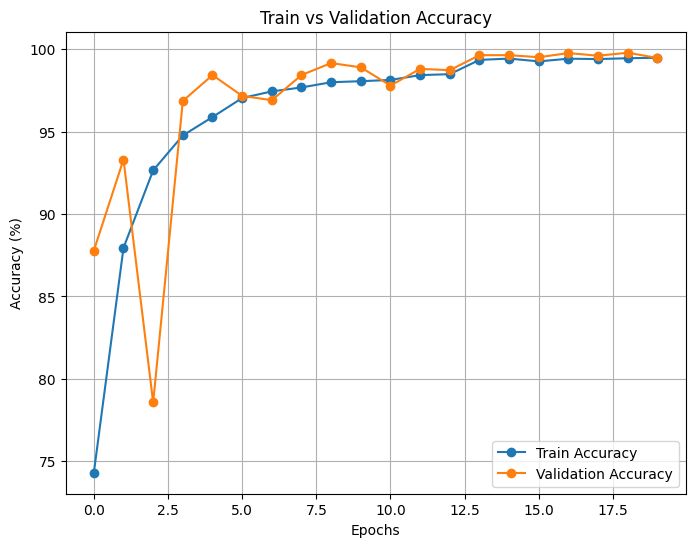

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(history["train_acc"], label="Train Accuracy", marker='o')
plt.plot(history["val_acc"], label="Validation Accuracy", marker='o')
plt.title("Train vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()


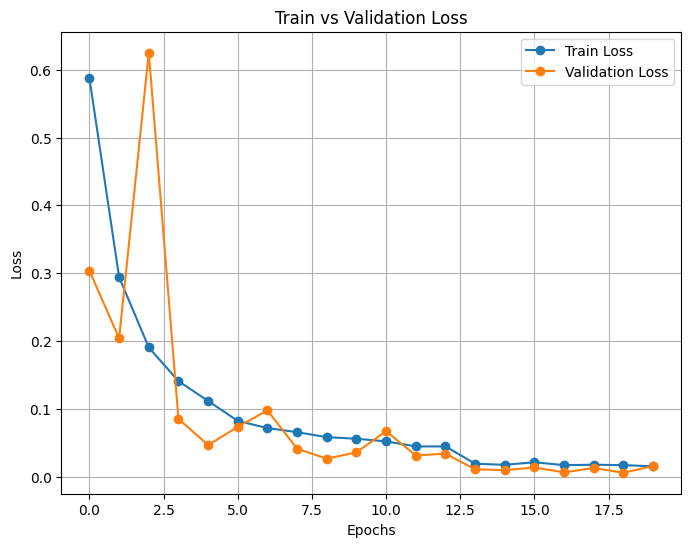

In [9]:
plt.figure(figsize=(8,6))
plt.plot(history["train_loss"], label="Train Loss", marker='o')
plt.plot(history["val_loss"], label="Validation Loss", marker='o')
plt.title("Train vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


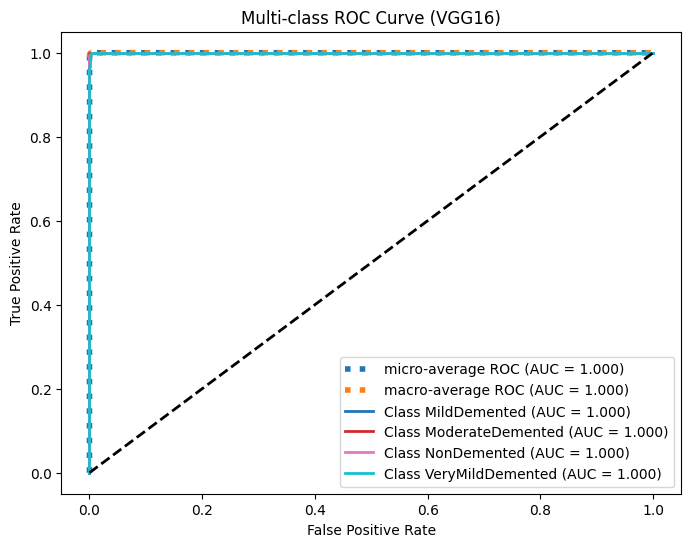

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np

# ==========================
# 1. Reload VGG16 with saved weights
# ==========================
model = get_vgg16_model(num_classes).to(device)
model.load_state_dict(torch.load("vgg16_best_valacc.pth", map_location=device))
model.eval()

# ==========================
# 2. Collect predictions on validation set
# ==========================
all_labels = []
all_probs = []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()

        all_probs.extend(probs)
        all_labels.extend(labels.numpy())

all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# ==========================
# 3. Binarize labels for ROC
# ==========================
y_true = label_binarize(all_labels, classes=range(num_classes))
n_classes = y_true.shape[1]

# ==========================
# 4. Compute ROC curve and AUC
# ==========================
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), all_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Macro-average
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# ==========================
# 5. Plot Multi-class ROC curve
# ==========================
plt.figure(figsize=(8,6))
plt.plot(fpr["micro"], tpr["micro"], label=f"micro-average ROC (AUC = {roc_auc['micro']:.3f})", linestyle=":", linewidth=4)
plt.plot(fpr["macro"], tpr["macro"], label=f"macro-average ROC (AUC = {roc_auc['macro']:.3f})", linestyle=":", linewidth=4)

colors = plt.cm.tab10(np.linspace(0, 1, n_classes))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"Class {full_dataset.classes[i]} (AUC = {roc_auc[i]:.3f})")

plt.plot([0,1], [0,1], "k--", lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC Curve (VGG16)")
plt.legend(loc="lower right")
plt.show()
